# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. X Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. X Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. X Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière continue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import numpy as np
import pandas as pd
import random
#pour supprimer les warnings sur retouche des copies de dataframe
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
from datetime import datetime
import itertools
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut
from iads import kmoyennes as km

from iads import hierarchie as hi

In [3]:
class ClassifierGradiantBatch(cl.Classifier):
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        v = np.random.rand(input_dimension)
        self.w = (2* v - 1) / np.linalg.norm(v)
        
    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        return np.dot(x, self.w)
    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        r = list(range(0,labeledSet.size(),1))
        random.shuffle(r)
        g = 0
        for i in range(labeledSet.size()):
            x = labeledSet.getX(r[i])
            g += (labeledSet.getY(r[i])-np.dot(self.w, x)) * x
        self.w += self.learning_rate * g
        return self.w
    
    def loss(self, dataset):
        l = 0
        for i in range(dataset.size()):
            l += (dataset.getY(i) - np.dot(self.w, dataset.getX(i)))**2
        return l / dataset.size()

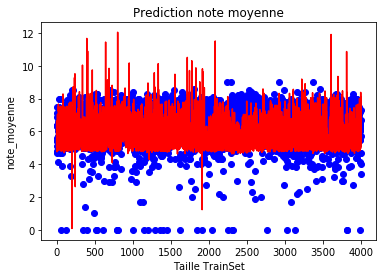

In [19]:
films = pkl.load(open("projet/data/film_v2.pkl", "rb"))
films=pd.DataFrame(films)
films= films[:10000]

d1= films[['popularity','release_date','vote_count','vote_average']]
d1= d1[d1['release_date'].str.len()==10] #filter ligne vide dans realease_date
d1['release_date']= d1['release_date'].apply(lambda l: float(l[0:4])) #on garde seulement l'année
d1= d1.fillna(d1.mean()) #on remplie les cellules nulles

labSet1 = ls.LabeledSet(3)
labSet1.addExamples(d1[['popularity','release_date','vote_count']].values ,d1[['vote_average']].values)
lset1, ltest1= ut.split(labSet1,0.6)

b1 = ClassifierGradiantBatch(3,1e-11)
nb= 100

pred = np.zeros(ltest1.size())
y= np.zeros(ltest1.size())
x= np.zeros(ltest1.size())

for i in range(0, nb):
    b1.train(lset1)

for i in range(0, ltest1.size()):
    pred[i]= b1.predict(ltest1.getX(i))
    y[i]= ltest1.getY(i)

    
plt.scatter(range(0, ltest1.size()),ltest1.y,  color='blue') 
plt.title('Prediction note moyenne') 
plt.xlabel('Taille TrainSet') 
plt.ylabel('note_moyenne')
plt.plot(range(0, ltest1.size()),pred,  color='red')

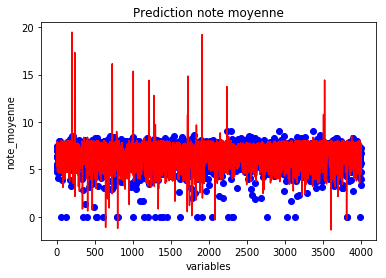

In [6]:
b1 = ClassifierGradiantBatch(3,1e-11)
nb= 100

pred = np.zeros(ltest1.size())

for i in range(0, nb):
    b1.train(lset1)

for i in range(0, ltest1.size()):
    pred[i]= b1.predict(ltest1.getX(i))
    
plt.scatter(range(0, ltest1.size()),ltest1.y,  color='blue') 
plt.title('Prediction note moyenne') 
plt.xlabel('variables') 
plt.ylabel('note_moyenne') 
plt.plot(range(0, ltest1.size()),pred,  color='red') 
plt.show()

## Chargement des données (base MovieLens + enrichissements)

In [21]:
#links = pd.read_csv('data/links.csv', encoding='utf8')
movies = pd.read_csv('data/movies.csv', encoding='utf8')
ratings = pd.read_csv('data/ratings.csv', encoding='utf8')
#tags = pd.read_csv('data/tags.csv', encoding='utf8')
# = pd.read_csv('data/genome-scores.csv', encoding='utf8')
#genome_tags = pd.read_csv('data/genome-tags.csv', encoding='utf8')

In [32]:
# Chargement des données complémentaires
acteurs = pkl.load(open("data/act_v2.pkl", "rb"))
films = pkl.load(open("data/film_v2.pkl", "rb"))
crews= pkl.load(open("data/crew_v2.pkl", "rb"))


In [33]:
films = pkl.load(open("data/film_v2.pkl", "rb"))
films=pd.DataFrame(films)
films= films[:10000]



In [24]:
acteurs= pd.DataFrame(list(itertools.chain.from_iterable(acteurs)))
data_crews= pd.DataFrame(list(itertools.chain.from_iterable(crews)))

In [6]:
acteurs.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/xxPMucou2wRDxLrud8i2D4dsywh.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/dDbtWMGdhatUjCIYolc312R2ygu.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


In [8]:
crews.head(10)

AttributeError: 'list' object has no attribute 'head'

In [9]:
films.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,"[16, 35, 10751]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",22.773,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,Toy Story,False,7.9,9550
1,False,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,"[12, 14, 10751]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,2.947,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg,1995-12-15,Jumanji,False,7.1,5594
2,False,/1ENbkuIYK2taNGGKNMs2hw6SaJb.jpg,"[35, 10749]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.076,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,Grumpier Old Men,False,6.5,140
3,False,/u0hQzp4xfag3ZhsKKBBdgyIVvCl.jpg,"[35, 18, 10749]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",2.917,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,1995-12-22,Waiting to Exhale,False,6.1,55
4,False,/cZs50rEk4T13qWedon0uCnbYQzW.jpg,[35],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.817,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,Father of the Bride Part II,False,6.1,288


ESTIMATION DE LA NOTE MOYENNE EN FONCTION DE LA POPULARITE, LA DATE (ET NOMBRE DE VOTE)

In [53]:




labSet2 = ls.LabeledSet(2)
labSet2.addExamples(d1[['popularity','release_date']].values,d1[['vote_average']].values)
lset2, ltest2= ut.split(labSet2,0.6)

In [54]:
d1.loc[d1.isnull().any(axis=1)]

,popularity,release_date,vote_count,vote_average


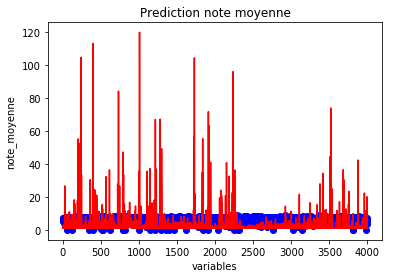

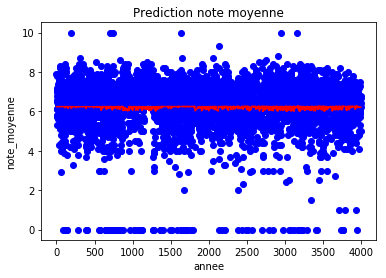

In [20]:
labSet1 = ls.LabeledSet(1)
labSet1.addExamples( d1[['release_date']].values ,d1[['vote_average']].values)
lset1, ltest1= ut.split(labSet1,0.6)

b1 = cl.ClassifierGradiantBatch(1,1e-11)
nb= 50

pred = np.zeros(ltest1.size())
y= np.zeros(ltest1.size())
x= np.zeros(ltest1.size())

for i in range(0, nb):
    b1.train(lset1)

for i in range(0, ltest1.size()):
    pred[i]= b1.predict(lset1.getX(i))
    y[i]= lset1.getY(i)
    x[i]= lset1.getX(i)

    
plt.scatter(range(0, ltest1.size()),y,  color='blue') 
plt.title('Prediction note moyenne') 
plt.xlabel('annee') 
plt.ylabel('note_moyenne') 
plt.plot(range(0, ltest1.size()),pred,  color='red') 

In [154]:
labSet2 = ls.LabeledSet(2)
labSet2.addExamples(d1[['popularity','release_date']].values,d1[['vote_average']].values)
lset2, ltest2= ut.split(labSet2,0.6)

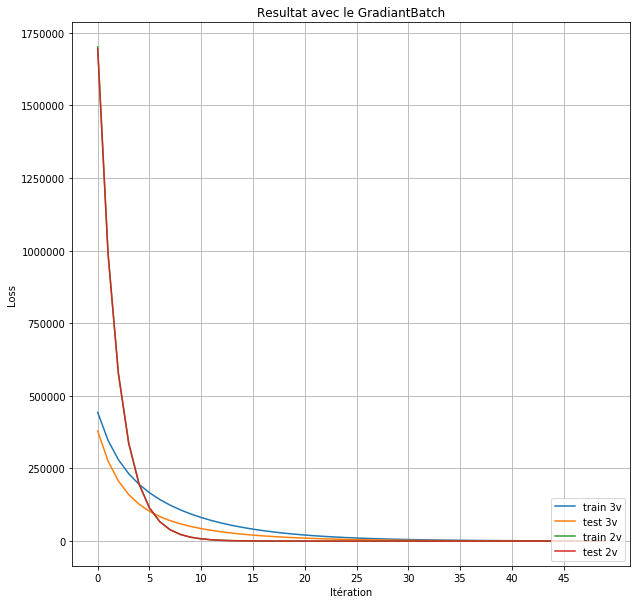

In [157]:
b1 = cl.ClassifierGradiantBatch(3,1e-11)
b2 = cl.ClassifierGradiantBatch(2,1e-11)
nb= 50

resloss1 = np.zeros(nb)
resloss1t = np.zeros(nb)
resloss2 = np.zeros(nb)
resloss2t = np.zeros(nb)

for i in range(0, nb):
    resloss1[i] = b1.loss(lset1)
    resloss1t[i] = b1.loss(ltest1)
    resloss2[i] = b2.loss(lset2)
    resloss2t[i] = b2.loss(ltest2)
    b1.train(lset1)
    b2.train(lset2)

fig,ax =plt.subplots(figsize=(10,10))
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(resloss1,label="train 3v")
ax.plot(resloss1t,label="test 3v")
ax.plot(resloss2,label="train 2v")
ax.plot(resloss2t,label="test 2v")
ax.legend(loc="lower right")
ax.set_xlabel("Itération")
ax.set_xticks(range(0,nb,int(nb/10)))
ax.set_ylabel("Loss")
ax.set_title("Resultat avec le GradiantBatch")
plt.show()

On peut observer que sur 50 itérations et une base de 5000 films, la note moyenne d'un film est grandement influencé par la popularité et l'année de film, et avec l'ajout du nombre de votant l'estimaion est 3 fois plus efficace.

PREDICTION D'UN FILM POUR ADULTE

In [130]:
d2= films[['popularity','vote_count','vote_average','adult']]
d2['adult']= d2['adult'].apply(lambda l: 1 if l==True else -1 )
d2= d2.fillna(d2.mean())
adu = ls.LabeledSet(3)
adu.addExamples(d2[['popularity','vote_average','vote_count']].values , d2[['adult']].values)
atrain, atest= ut.split(adu,0.6)

In [164]:
# nb=100
# ltrain = np.zeros(nb)

# k = range(1,nb,1)
# for i in k:
#     foret = cl.ClassifierRandomForest(i, 0.3,0.99, True)
#     foret.train(atest)
#     valid= 0
#     for j in range(atest.size()):
#         if foret.predict(atest.getX(j)) == atest.getY(j):
#             valid += 1
#     ltrain[i]= (valid/atest.size())
    
# fig,ax =plt.subplots(figsize=(10,10))
# ax.grid(True)
# ax.set_axisbelow(True)
# ax.plot(ltrain,label="test")
# ax.legend(loc="lower right")
# ax.set_xlabel("Itération")
# ax.set_xticks(range(1,nb,int(nb/10)))
# ax.set_ylabel("accuracy")
# ax.set_title("Resultat avec le RandomForest")
# plt.show()

nb=10
ltrain = []

k = range(1,nb,1)
for i in k:
    foret = cl.ClassifierBaggingTreeOOB(i, 0.3,0.99, True)
    foret.train(atrain)
    ltrain.append(foret.taux())

plt.plot(k,ltrain, label="taux")
plt.legend(loc="best")
plt.show()


KeyboardInterrupt: 

On peut observer que l'accuracy est très élevé pour une classification avec RandomForest, les variables utilisées sont donc plutot pertinents.

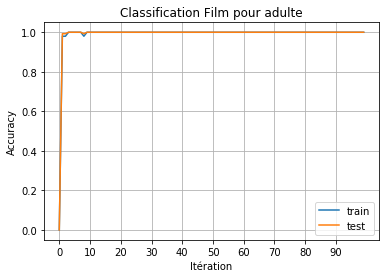

In [165]:
classpercptron = cl.ClassifierPerceptron(3,0.001)
nb=100
res1 = np.zeros(nb)
res2 = np.zeros(nb)


for i in range(0,nb):
    res1[i] = classpercptron.accuracy(atrain)
    res2[i] = classpercptron.accuracy(atest)
    classpercptron.train(atrain)
    
fig,ax =plt.subplots()
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(res1,label="train")
ax.plot(res2,label="test")
ax.legend(loc="best")
ax.set_xlabel("Itération")
ax.set_xticks(range(0,nb,int(nb/10)))
ax.set_ylabel("Accuracy")
ax.set_title("Classification Film pour adulte")
plt.show()


In [142]:
data_crews.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/gasNitCwepbqNcYBmDHpsCgZH0I.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/cCJDIvQatfefZtB9cI49S2L3erC.jpg
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


In [182]:
data_crews = data_crews.drop(['profile_path'], axis=1)
data_crews = data_crews.drop(['credit_id'], axis=1)
s = list(set(data_crews['job']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
data_crews['job'] = data_crews['job'].apply(lambda e : dico[e])
data_crews['job'] = data_crews['job'].astype(int)

s = list(set(data_crews['name']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
data_crews['name'] = data_crews['name'].apply(lambda e : dico[e])
data_crews['name'] = data_crews['name'].astype(int)
print(list(set(data_crews['department'])))
dc = pd.concat([pd.get_dummies(data_crews['department']),data_crews.drop(['department'], axis=1)],axis=1)
dc

['Art', 'Visual Effects', 'Crew', 'Camera', 'Editing', 'Sound', 'Writing', 'Actors', 'Lighting', 'Costume & Make-Up', 'Directing', 'Production']


,Actors,Art,Camera,Costume & Make-Up,Crew,Directing,Editing,Lighting,Production,Sound,Visual Effects,Writing,gender,id,job,name
0,0,0,0,0,0,1,0,0,0,0,0,0,2,7879,346,19627
1,0,0,0,0,0,0,0,0,0,0,0,1,2,12891,290,49784
2,0,0,0,0,0,0,0,0,0,0,0,1,2,7,290,73421
3,0,0,0,0,0,0,0,0,0,0,0,1,2,12892,290,112690
4,0,0,0,0,0,0,0,0,0,0,0,1,0,12893,290,95522
5,0,0,0,0,0,0,0,0,1,0,0,0,1,12894,717,63029
6,0,0,0,0,0,0,0,0,1,0,0,0,2,12895,487,108485
7,0,0,0,0,0,0,0,0,1,0,0,0,2,12896,717,129850
8,0,0,0,0,0,0,0,0,1,0,0,0,2,12897,487,29486
9,0,0,0,0,0,0,1,0,0,0,0,0,2,8,149,63287


In [183]:

d= km.normalisation(dc.iloc[: , 12:])
d = pd.concat([dc.iloc[:, :12], d], axis=1)
d = d.values.astype(float)

In [176]:
def clustering_hierarchique(train, s):
      # clustering courant, au départ:s données data_2D normalisées
    M_Fusion = []                        # initialisation
    while len(train) >=2:              # tant qu'il y a 2 groupes à fusionner
        new,k1,k2,dist_min = hi.fusionne(s,train)
        if(len(M_Fusion)==0):
            M_Fusion = [k1,k2,dist_min,2]
        else:
            M_Fusion = np.vstack( [M_Fusion,[k1,k2,dist_min,2] ])
        train = new
        
    plt.figure(figsize=(30, 15)) # taille : largeur x hauteur
    plt.title('Dendrogramme', fontsize=25)    
    plt.xlabel('Exemple', fontsize=25)
    plt.ylabel('Distance', fontsize=25)

    # Construction du dendrogramme à partir de la matrice M_Fusion:
    scipy.cluster.hierarchy.dendrogram(
        M_Fusion,
        leaf_font_size=18.,  # taille des caractères de l'axe des X
    )
    plt.show()
    return M_Fusion

In [184]:
hi.clustering_hierarchique(d, "euclidienne")

KeyboardInterrupt: 

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [8]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in acteurs:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
# Dans combien de comédies...

# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches

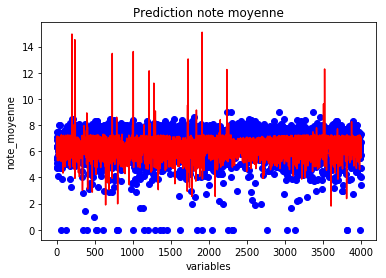